In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# 데이터로더 구성 

- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스로 스트링으로 변환
- X_train, y_train , X_test, y_test, word_to_index리턴

In [3]:
import re
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','과','도','를','으로','자','에','와','한','하다', '이다']

def load_data(train_data, test_data, num_words=10000):
    # 1) 특수기호 및 공백 제거
    train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', train_data['document'])
    
    train_data['document'] = train_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)
    
    # 2) 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)    # subset에 중복데이터를 처리할 칼럼명을 전달
    train_data = train_data.dropna(how = 'any')    # NaN이 있으면 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 3) 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 4) 단어사전 구성
    words = np.concatenate(X_train).tolist() # 단어들을 리스트로 저장
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   # count기준 상위 num_words-4개의 단어로 축소
    #print(counter)
    vocab = ['', '', '', ''] + [key for key, _ in counter]    # 리스트 5번째부터 토큰화한 단어가 count 큰 순으로 저장됨
    #print(vocab)
    word_to_index = {word:index for index, word in enumerate(vocab)}    # 키: 단어, 값: 인덱스(3~num_words-1)
    #print(word_to_index)
    
    # 5) 텍스트 문자열을 사전인덱스 문자열로 변환
    def wordlist_to_indexlist(wordlist):
        # 키==단어이면 단어의 인덱스, 해당하는 단어가 없으면 3
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # X_train 또는 X_test의 모든 원소에 wordlist_to_indexlist함수를 적용시킨 결과들을 리스트로 저장
    # X_train과 X_test는 각 문장에 있는 모든 단어가 담긴 이중리스트였으므로
    # 원래 단어가 있던 곳에 해당하는 인덱스가 들어간 이중리스트가 된다.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

vocab_size = 30000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=vocab_size) 

/tmp/ipykernel_3033/881825640.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_3033/881825640.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


In [4]:
print(X_train[:10])
print(y_train[:10])

[[27, 68, 894, 33, 216, 15, 28, 701], [997, 483, 494, 639, 4, 112, 1556, 47, 867, 950, 11, 38, 366], [19, 194, 28635], [8034, 145, 4134, 280, 88, 13, 5, 52, 3329], [21628, 8491, 1052, 47, 2701, 55, 4, 2623, 34, 1119, 29, 325, 36, 17, 35, 55, 15312, 21629, 395, 2878, 1677, 5], [628, 21630, 17796, 427, 173, 1465, 663, 1593, 672, 46, 28636, 4, 62, 2169, 120, 723], [239, 352, 8, 356, 1921, 51, 11, 782, 5], [235, 1360, 135, 5, 393, 710, 10358, 15313, 47, 1435, 271, 94, 234, 23, 889, 24, 323, 611, 503, 478, 549, 5, 3168, 8492, 17, 1385, 1385, 67, 284, 13, 5, 47, 97, 7, 70, 17, 28637, 37], [118, 13, 18, 88, 12, 271, 22, 43, 4], [58, 615, 52, 227, 708, 535, 83, 17, 480, 1405, 599, 691, 75, 17, 19, 15314, 12, 15]]
[0 1 0 0 1 0 0 0 1 1]


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
# index_to_word

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [7]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[2])
print(index_to_word[3])
#print(index_to_word)

<PAD>
<BOS>
<UNK>
<UNUSED>


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.528138730242716
문장길이 최대 :  105
문장길이 표준편차 :  11.921158321890513
pad_sequences maxlen :  38
전체 문장의 0.9352204879212769가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(143620, 38)


# 모델 구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [10]:
# validation set 40000건 분리 (약30%)
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 약 11만건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(103620, 38)
(103620,)


In [11]:
word_vector_dim = 100 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

from keras.layers.core import Dropout

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # LSTM레이어. LSTM state 벡터의 차원수는 128로 함. (변경 가능)
# model.add(Dropout(0.2))
# model.add(keras.layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1차원데이터이다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,117,377
Trainable params: 3,117,377
Non-trainable params: 0
_________________________________________________________________


In [12]:
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 3,000,817
Trainable params: 3,000,817
Non-trainable params: 0
_________________________________________________________________


In [13]:

from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

# 모델 훈련

In [14]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=2)

Epoch 1/10
810/810 - 8s - loss: 0.4386 - accuracy: 0.7820 - val_loss: 0.3522 - val_accuracy: 0.8458
Epoch 2/10
810/810 - 5s - loss: 0.3089 - accuracy: 0.8706 - val_loss: 0.3498 - val_accuracy: 0.8521
Epoch 3/10
810/810 - 5s - loss: 0.2501 - accuracy: 0.8980 - val_loss: 0.3657 - val_accuracy: 0.8493
Epoch 4/10
810/810 - 5s - loss: 0.2055 - accuracy: 0.9189 - val_loss: 0.4005 - val_accuracy: 0.8387
Epoch 5/10
810/810 - 5s - loss: 0.1693 - accuracy: 0.9345 - val_loss: 0.4606 - val_accuracy: 0.8445
Epoch 6/10
810/810 - 5s - loss: 0.1424 - accuracy: 0.9452 - val_loss: 0.4832 - val_accuracy: 0.8443
Epoch 7/10
810/810 - 5s - loss: 0.1229 - accuracy: 0.9541 - val_loss: 0.5508 - val_accuracy: 0.8377


In [16]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5751 - accuracy: 0.8214
[0.5750633478164673, 0.8214293122291565]


In [17]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=10  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/10
810/810 [==============================] - 3s 4ms/step - loss: 0.4506 - accuracy: 0.8002 - val_loss: 0.3681 - val_accuracy: 0.8351
Epoch 2/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3498 - accuracy: 0.8495 - val_loss: 0.3556 - val_accuracy: 0.8438
Epoch 3/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3294 - accuracy: 0.8611 - val_loss: 0.3524 - val_accuracy: 0.8460
Epoch 4/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3181 - accuracy: 0.8675 - val_loss: 0.3525 - val_accuracy: 0.8454
Epoch 5/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3112 - accuracy: 0.8713 - val_loss: 0.3535 - val_accuracy: 0.8460
Epoch 6/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3057 - accuracy: 0.8742 - val_loss: 0.3539 - val_accuracy: 0.8462
Epoch 7/10
810/810 [==============================] - 3s 3ms/step - loss: 0.3006 - accuracy: 0.8768 - val_loss: 0.3526 - val_accuracy: 0.8464
Epoch 

In [18]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3638 - accuracy: 0.8395
[0.36384817957878113, 0.8395141959190369]


In [19]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 6s 3ms/step - loss: 0.2937 - accuracy: 0.8800 - val_loss: 0.3546 - val_accuracy: 0.8453
Epoch 2/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2910 - accuracy: 0.8821 - val_loss: 0.3542 - val_accuracy: 0.8461
Epoch 3/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2869 - accuracy: 0.8850 - val_loss: 0.3582 - val_accuracy: 0.8450
Epoch 4/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2825 - accuracy: 0.8872 - val_loss: 0.3608 - val_accuracy: 0.8443
Epoch 5/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2783 - accuracy: 0.8898 - val_loss: 0.3618 - val_accuracy: 0.8445
Epoch 6/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2743 - accuracy: 0.8913 - val_loss: 0.3611 - val_accuracy: 0.8458
Epoch 7/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2708 - accuracy: 0.8930 - val_loss: 0.3588 - val_accuracy:

In [20]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3716 - accuracy: 0.8375
[0.37163516879081726, 0.8375205993652344]


In [21]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [22]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=20  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
810/810 [==============================] - 4s 4ms/step - loss: 0.2658 - accuracy: 0.8949 - val_loss: 0.3558 - val_accuracy: 0.8468
Epoch 2/20
810/810 [==============================] - 3s 4ms/step - loss: 0.2306 - accuracy: 0.9112 - val_loss: 0.3672 - val_accuracy: 0.8444
Epoch 3/20
810/810 [==============================] - 3s 4ms/step - loss: 0.1912 - accuracy: 0.9298 - val_loss: 0.3883 - val_accuracy: 0.8387
Epoch 4/20
810/810 [==============================] - 3s 4ms/step - loss: 0.1514 - accuracy: 0.9464 - val_loss: 0.4282 - val_accuracy: 0.8334
Epoch 5/20
810/810 [==============================] - 3s 4ms/step - loss: 0.1162 - accuracy: 0.9603 - val_loss: 0.4750 - val_accuracy: 0.8263
Epoch 6/20
810/810 [==============================] - 3s 4ms/step - loss: 0.0864 - accuracy: 0.9723 - val_loss: 0.5279 - val_accuracy: 0.8217


In [23]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5258 - accuracy: 0.8147
[0.5258303880691528, 0.8146957755088806]


In [24]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model3.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [25]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 6s 6ms/step - loss: 0.5005 - accuracy: 0.7255 - val_loss: 0.3695 - val_accuracy: 0.8384
Epoch 2/15
810/810 [==============================] - 5s 6ms/step - loss: 0.3344 - accuracy: 0.8575 - val_loss: 0.3443 - val_accuracy: 0.8464
Epoch 3/15
810/810 [==============================] - 5s 6ms/step - loss: 0.3024 - accuracy: 0.8729 - val_loss: 0.3235 - val_accuracy: 0.8567
Epoch 4/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2796 - accuracy: 0.8841 - val_loss: 0.3292 - val_accuracy: 0.8594
Epoch 5/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2591 - accuracy: 0.8944 - val_loss: 0.3418 - val_accuracy: 0.8547
Epoch 6/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2412 - accuracy: 0.9031 - val_loss: 0.3250 - val_accuracy: 0.8584
Epoch 7/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2250 - accuracy: 0.9114 - val_loss: 0.3337 - val_accuracy: 0.8596
Epoch 

In [26]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3557 - accuracy: 0.8492
[0.35565832257270813, 0.8492178320884705]


In [27]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [28]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 11s 6ms/step - loss: 0.4702 - accuracy: 0.7510 - val_loss: 0.3613 - val_accuracy: 0.8413
Epoch 2/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.3307 - accuracy: 0.8572 - val_loss: 0.3315 - val_accuracy: 0.8541
Epoch 3/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.3013 - accuracy: 0.8727 - val_loss: 0.3264 - val_accuracy: 0.8552
Epoch 4/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2770 - accuracy: 0.8868 - val_loss: 0.3209 - val_accuracy: 0.8606
Epoch 5/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.2563 - accuracy: 0.8971 - val_loss: 0.3207 - val_accuracy: 0.8617
Epoch 6/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2380 - accuracy: 0.9054 - val_loss: 0.3316 - val_accuracy: 0.8594
Epoch 7/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2218 - accuracy: 0.9121 - val_loss: 0.3333 - val_accurac

In [29]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4093 - accuracy: 0.8411
[0.4092542827129364, 0.8411213159561157]


In [30]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)


Epoch 1/15
1620/1620 [==============================] - 11s 6ms/step - loss: 0.4648 - accuracy: 0.7574 - val_loss: 0.3511 - val_accuracy: 0.8466
Epoch 2/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.3322 - accuracy: 0.8569 - val_loss: 0.3460 - val_accuracy: 0.8456
Epoch 3/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.3038 - accuracy: 0.8713 - val_loss: 0.3276 - val_accuracy: 0.8565
Epoch 4/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2789 - accuracy: 0.8849 - val_loss: 0.3201 - val_accuracy: 0.8599
Epoch 5/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2570 - accuracy: 0.8969 - val_loss: 0.3171 - val_accuracy: 0.8616
Epoch 6/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2391 - accuracy: 0.9052 - val_loss: 0.3467 - val_accuracy: 0.8529
Epoch 7/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2222 - accuracy: 0.9124 - val_loss: 0.3368 - val_accuracy

In [32]:
results = model3.evaluate(X_test,  y_test, verbose=1)

print(results)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3991 - accuracy: 0.8403
[0.3991478681564331, 0.8402872681617737]


In [33]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model3.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3274 - accuracy: 0.8552

 테스트 정확도: 0.8552


Loss, Accuracy 그래프 시각화

In [34]:
history_dict = history3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


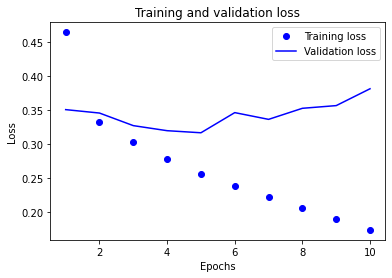

In [35]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

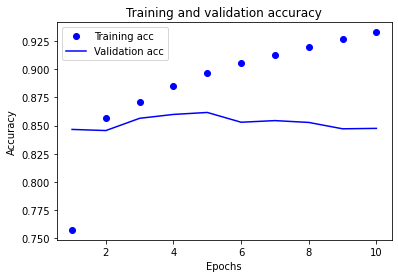

In [36]:
plt.clf()   # 그림을 초기화합니다
## 모델1 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습된 Embedding 레이어 분석

In [37]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 2s 2ms/step - loss: 0.3676 - accuracy: 0.8390

 테스트 정확도: 0.8390


In [38]:
embedding_layer = loaded_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 100)


In [39]:
import os

vocab_size = weights.shape[0]
word_vector_dim = weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = loaded_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 저장한 워드 벡터 다시 로드
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.06178759, -0.21925198,  0.65681285, -0.1815251 , -0.39898357,
       -0.0929231 , -0.03888755, -0.31980428, -0.42889363, -0.50349456,
       -0.23777167, -0.07175514, -0.02905947, -0.1139995 , -0.23474689,
       -0.2123156 , -0.02677905, -0.12182406, -0.3993658 , -0.20692235,
       -0.44685778, -0.20098427, -0.372344  , -0.28518093, -0.17958622,
       -0.242259  , -0.08838418,  0.06694317, -0.43213952, -0.40420213,
       -0.34640864, -0.4294388 , -0.18762204, -0.46668684, -0.5171174 ,
       -0.39477545, -0.4054623 , -0.16137923, -0.17977767, -0.33106974,
       -0.14512481, -0.34099832, -0.22880287,  0.73889714, -0.37008777,
       -0.11684783, -0.2221512 , -0.3720211 ,  0.02327181,  0.0460037 ,
       -0.49241376, -0.3937263 , -0.05555035, -0.37928432, -0.40478218,
       -0.34587198, -0.18992038, -0.17190391, -0.29637748, -0.2615887 ,
       -0.4063239 , -0.45796847, -0.42435113, -0.23212206, -0.47834933,
       -0.32957047, -0.15279128, -0.10860041, -0.41864514, -0.40

In [41]:
keys = []
for key, distance in word_vectors.similar_by_word('영화'):
    print(key)
    keys.append(word_to_index[key])

함
로맨스
하
다
같
반
났
완성도
뭔가
온다


In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y = tsne.fit_transform(weights)
y.shape

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(30000, 2)

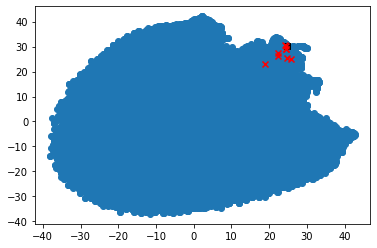

In [43]:
plt.scatter(y[:,0], y[:,1])
for idx, key in enumerate(keys):            
    if idx == 0:
        plt.scatter(y[key,0], y[key,1], marker='s', c='black')
        continue
    plt.scatter(y[key,0], y[key,1], marker='x', c='r')

In [44]:
import gensim
import os

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [45]:
word2vec.wv.most_similar('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [46]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [47]:
from tensorflow.keras.layers import GRU
from keras.layers.core import Dropout
from tensorflow.keras.initializers import Constant

# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(GRU(128))
model4.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 38, 100)           3000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,088,449
Trainable params: 3,088,449
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model4.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [49]:
# 학습의 진행
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
810/810 [==============================] - 7s 7ms/step - loss: 0.5690 - accuracy: 0.6689 - val_loss: 0.4054 - val_accuracy: 0.8152
Epoch 2/15
810/810 [==============================] - 5s 6ms/step - loss: 0.3730 - accuracy: 0.8329 - val_loss: 0.3529 - val_accuracy: 0.8395
Epoch 3/15
810/810 [==============================] - 5s 6ms/step - loss: 0.3191 - accuracy: 0.8612 - val_loss: 0.3324 - val_accuracy: 0.8550
Epoch 4/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2846 - accuracy: 0.8782 - val_loss: 0.3271 - val_accuracy: 0.8588
Epoch 5/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2567 - accuracy: 0.8931 - val_loss: 0.3308 - val_accuracy: 0.8585
Epoch 6/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2316 - accuracy: 0.9053 - val_loss: 0.3308 - val_accuracy: 0.8609
Epoch 7/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2069 - accuracy: 0.9164 - val_loss: 0.3414 - val_accuracy: 0.8614
Epoch 

In [50]:
results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4064 - accuracy: 0.8513
[0.4063548445701599, 0.8512927889823914]


In [51]:
loaded_model = load_model('best_model4.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3363 - accuracy: 0.8525

 테스트 정확도: 0.8525


In [52]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


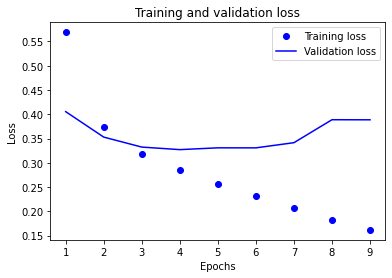

In [53]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

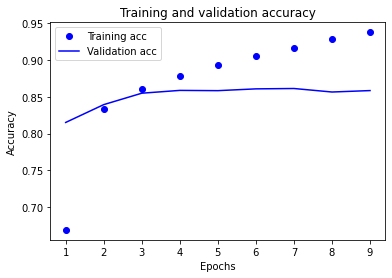

In [54]:
plt.clf()   # 그림을 초기화합니다
## 모델1 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고 

이번 익스는 굉장히 어려워서 정말 하나도 모르겠어서 다른 사람들이 한것을 참고하였습니다 
